<a href="https://colab.research.google.com/github/audrb1999/Paper_review/blob/main/07.ZeRO-Inference%3A%20Democratizing%20massive%20model%20inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 경량화 기법: large scale model의 효율적으로 train or retrain을 하기 위해서 정확도를 유지하며 모델 크기를 줄이는 방법을 찾아보자
  - large scale model의 근본적인 문제를 해결해주지만 정확도와 모델 크기의 trade off가 존재함

- 분산 학습: large model을 효율적으로 train or retrain을 하기 위한 방법을 찾아보자






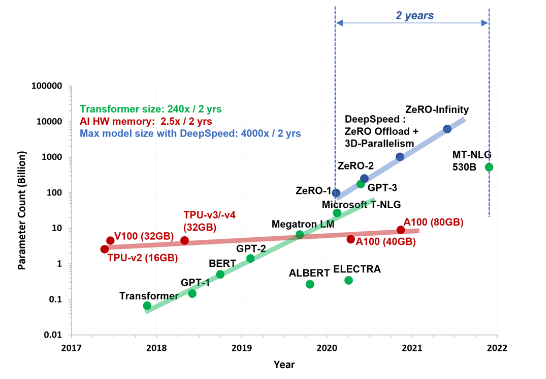

모델의 크기를 늘리는 방법은 간단하게 성능 증가를 얻을 수 있는 방법입니다.

위의 사진을 보면 지난 5년 동안 모델의 파라미터 량이 크게 증가한 것을 알 수 있습니다.

이런 대규모 모델의 교육에 대해서 기존에는 사용자가 직접 관리를 했는데 이 경우 오류가 발생하기 쉬웠습니다.(distributed training infra  설정 등)




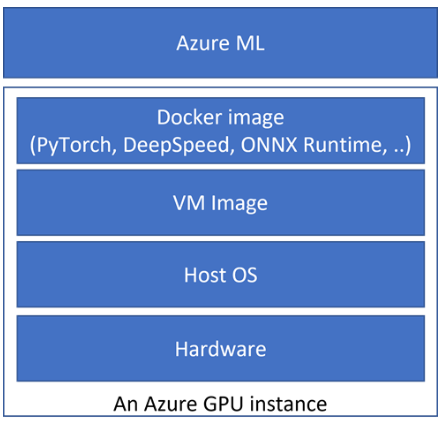

위 사진은  scalable한 분산학습(scalable distributed training)을 위한 Microsoft full-stack optimization 입니다.

이 최적화된 스택을 통해 Azure에서 DeepSpeed를 사용하여 대규모 모델의 교육을 효율적으로 scale 할 수 있습니다.

# ZeRO-Inference: Democratizing massive model inference

다양한 도메인 task에서 모델 크기를 늘리면 좋은 성능을 얻을 수 있습니다.

자연어 처리 SOTA 모델 경향을 본다면 4년전 3억 개의 파라미터(Bert - Large)에서 5,000 억 개의 파라미터(Megatrom - Turing - 530B)로 급격하게 성장했습니다.

이러한 급격한 증가는 모델의 train, retrain, fine - tuning, inference 과정에서 GPU 비용이 크게 증가하여 대부분의 사용자가 비용을 감당할 수 없습니다.

- ex) GPT3는 수 천개의 TPU를 사용해서 몇 주간 학습해야하므로 retrain이 어려운 문제가 존재함



여러 기업들이 pre trained model을 제공하지만 이런 모델 조차도 inference 하는데 수십 개의 GPU가 필요합니다.

- 여러 제한 사항 때문에 다양하게 활용이 불가능함!

이러한 문제를 해결하기 위해서 ZeRO - inference 기술을 개발

이전에 이기종 시스템(Heterogeneous System)을 활용하여 모델 교육을 효율적으로 확장하는 기술인 ZeRO-infinity를 개발했었는데 이번 기술은 CPU, NVMe 메모리에 모델 가중치를 호스팅하여 GPU에서 모델 추론을 위한 ZeRO-infinity 기술을 조정하고 최적화 합니다.

## How ZeRO-Inference works

대규모 모델 추론의 계산량은 GPU와 같은 가속기가 필요합니다.

제한된 GPU 예산에서 대규모 모델 추론을 위한 가장 중요한 과정은 모델 가중치, 추론 입력 및 중간 결과 간에 GPU 메모리를 할당하는 것입니다.

### Offload all model weights

ZeRO-Inference는 전체 모델 가중치를 CPU 또는 NVMe 에 고정하고 추론 계산을 위해 가중치를 계층별로 GPU로 스트리밍합니다.

레이어를 계산한 후 출력은 다음 레이어의 입력으로 GPU 메모리에 저장되는 반면 레이어 가중치에 의해 소비된 메모리(가중치 저장)는 다음 레이어에서 사용하기 위해 해제됩니다.

- 스트리밍(Streaming): 네트워크를 통한 데이터를 실시간으로 받아옴, 즉 GPU가 실시간으로 레이어 가중치를 받아온다는 것

왜 이것을 해제하는가?

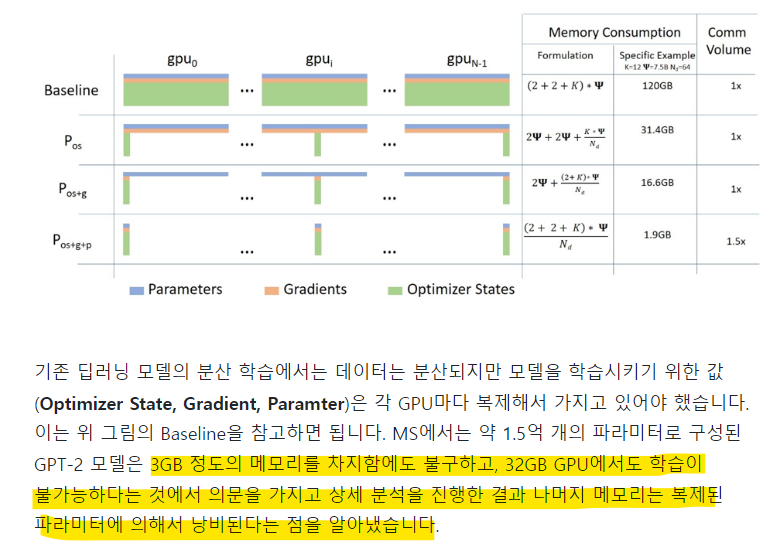

https://velog.io/@seoyeon96/%EB%A6%AC%EC%84%9C%EC%B9%98-%ED%9A%A8%EC%9C%A8%EC%A0%81%EC%9D%B8-%EB%B6%84%EC%82%B0-%ED%95%99%EC%8A%B5%EC%9D%84-%EC%9C%84%ED%95%9C-DeepSpeed-ZeRO

즉 cpu에 모든 가중치를 올려두고 추론 계산을 위해서 gpu에다 각 레이어 별로 실시간으로 전달해준다는거

따라서 모델 추론 시간은 GPU에서 레이어를 계산하는 시간과 PCIe를 통해 레이어를 가져오는 시간으로 구성됩니다.

이로 인해 생기는 이점

- ZeRO-Inference는 언제든지  GPU 메모리에 하나(또는 몇 개)의 모델 계층만 유지함으로써 대규모 모델을 추론하는 데 필요한 GPU 메모리의 양을 크게 줄입니다.

- PCle는 주변 장치와 기타 구성 요소간의 고 대역폭 연결역할을 함

ZeRO-Inference는 PCIe 상호 연결을 통해 CPU 또는 NVMe에서 모델 가중치를 가져오는 대기 시간에도 불구하고 처리량 지향 추론 애플리케이션을 위한 효율적인 계산을 제공합니다.

어떻게 효율적인 계산을 제공하냐?

- GPU 메모리를 사용을 1개 또는 몇 개의 가중치 계층으로 제한함으로써 zero infernce가 대부분의 gpu 메모리를 사용하여 긴 시퀀스 또는 대규모의 형태로 많은 양의 입력 토큰을 지원함

- 즉 가중치가 차지하는 메모리 량을 줄이고 긴 시퀀스나 대규모의 입력 토큰을 사용해서

배치 크기. 대규모 모델 계층은 특히 입력 토큰이 많은 입력을 처리할 때 상당한 양의 계산이 필요합니다

### 최적화

시스템 효율성을 더욱 향상시키기 위해 ZeRO-Inference는 두 가지 추가 최적화를 활용하여 CPU 또는 NVMe 메모리에서 GPU 메모리로 계층 가중치를 가져오는 대기 시간을 줄입니다.

첫 번째는 계층의 fetching을 이전 계층의 prefetching 추출 계산과 중첩하는 것

ZeRO infernce가 중첩으로 인해 perfetch 전송 지연 시간을 일부 무시된다. 이는 계산 시간이 크지않고 배치 크기가 더 큰 경우, 계층 가중치를 가져오는 지연 시간을 조정할 수 없을 때 유용하다.

- 그니까 현재 레이어를 가져올 때 이전 레이어 계산을 같이 진행한다는 것?

두 번째 최적화는 각 CPU를 사용하여 계층의 일부만 가져오는 방식을 통해서 병렬화로 처리하는 것 이러면 여러 GPU가 동시에 작업하기 때문에 GPU의 총 PCle 링크를 사용하면 전송 대역폭이 선형적으로 증가하여 대기 시간이 줄어듬

- 레이어 가져올 때 이전 레이어의 계산이 같이 일어남, 레이어 prefetching과 겹친 것 이를 통해 ZeRO-Inference는 프리페치 된 레이어의 전송 대기 시간 부분을 없앰
  - 는 계산 시간이 충분히 크지 않거나 레이어 가중치를 가져오는 대기 시간을 지배할 만큼 충분히 늘릴 수 없는 경우(예: 더 큰 배치 크기)에 특히 유용합니다.

- 두번째는 각 gpu를 사용해서 계층의 일부만 가져오는 방식으로 여러 GPU에서 각 계층의 가져오기를 병렬화하여 진행
 - 한번에 여러 계층들을 가져온다는 것, 레이어 프리패치를 병렬로 진행
 - 이 접근 방식을 사용하면 레이어를 GPU 메모리로 가져오는 작업이 두 단계로 이루어집니다.
 1. 각 GPU가 PCle를 통해 나눈 모델을 독립적으로 가져옴(여기서는 각 레이어의 파티션이 gpu들에만 상주)
 2. 각 GPU는 고대역폭 GPU-GPU 상호연결(NVLink, xGMI)를 통해서 다른 gpu에서 누락된 계층 조각을 가져와 전체를 조립(각 gpu가 연동되어서 조립)

또 다른 방식

- GPu 메모리에서 일부 모델 가중치를 호스팅
  - 호스팅: 서버 컴퓨터의 전체 또는 일정 공간을 이용할 수 있도록 임대해주는 것, 즉 gpu 메모리에 일부 모델 가중치를 올려둔다

 가능한 많은 모델 가중치를 GPU 메모리에 올려두고 계산이 필요할 때 나머지를 가져오는 방법(CPU or NVMe에서 가져오기)을 통해서 대기 시간을 방지

- 이 방식에는 2가지 단점이 존재
 1. 수천억 개의 매개 변수 모델에 대한 지연 시간 절약이 안될 때가 존재
  - 가중치의 일부분만 GPU 메모리에 들어갈 수 있기 때문

 2. inference 처리량을 해침 = 왜 그런지 찾아보지

##GPU에서 모델 스케일링

GPU에서 추론 계산에 지원되는 최대 모델 크기는 모델이 호스팅되는 메모리에 따라 다르다.

- 아래 사진은 GPU 추론을 위해 zero inference를 사용하여 사용 가능한 모델 스케일링을 보여줌

- Zero infernce는  hbm과 다른 메모리에서 모델을 호스팅할 수 있는 유연성이 존재하기 때문데 기준보다 훨씬 더 큰 모델을 지원할 수 있다



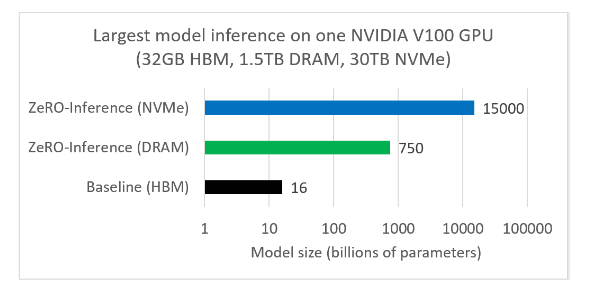

## 성능

제로 인퍼런스는 처리량 중심 추론 어플리케이션을 대상으로 함

- 이 워크로드에 사용하는 성능 지표는 생성 단계에서 초당 생성되는 토근 수


실험 방법

- Hugging Face 토큰 생성 파이프라인을 사용하여 탐욕스러운 검색 알고리즘을 사용하여 4개의 토큰 입력 프롬프트가 주어지면 10개의 출력 토큰을 생성하는 성능을 측정합니다.

- 실험의 생성 파이프라인은 KV 캐싱 최적화를 사용하여 생성된 토큰을 캐싱하여 재계산을 방지함으로써 성능을 개선합니다.

세 가지 방법이 성능에 미치는 영향을 알아봄


1. 부분 오프로딩이 아닌 전체 오프로딩 모델 가중치

2. 사용 전에 레이어 가중치 미리 가져오기

3. 다중 GPU를 사용하여 레이어 병렬화 PCIe를 통해 가져오는 것

  - 이것들은 전부 위에서 말한 것들임

###사용모델

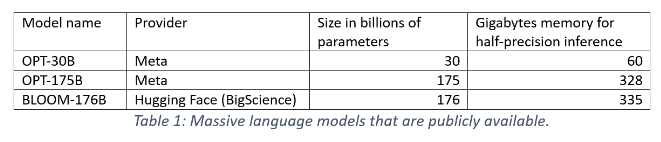

3가지 대규모 언어 모델을 사용하는데 GPU 메모리 보다 크기 때문에 단일 v100 - 32GB에서 이런 모델을 추론할려면 ZeRO inference 가 필요

1. 전체 오프로딩 모델 가중치
  - 오프로드란?
  - 전달되는 데이터의 양을 줄여 다른 사용자의 대역폭을 확보
  - 즉 모델 데이터 양을 줄여 대역폭 확보? 이런 느낌

- ZeRO offload의 설계 핵심은 GPU 메모리보다 큰 모델의 모든 가중치를 오프로드 하는 것

전체 오프로드로 활성화된 더 큰 배치 크기가 부분 오프로드보다 더 나은 성능을 제공


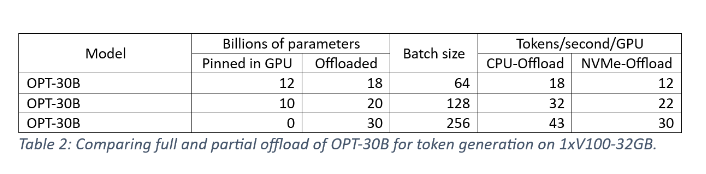


> 결과는 전체 오프로드가 CPU 메모리(초당 43개 토큰)와 NVMe 메모리(초당 30개 토큰) 모두에 대해 최상의 성능을 제공한다는 것을 보여줍니다. CPU와 NVMe 메모리 모두에서 전체 오프로드는 각각 180억 및 200억 매개변수의 부분 오프로드보다 1.3배 이상, 2.4배 이상 빠릅니다. 전체 오프로드의 성능 이점은 부분 오프로드 옵션에 비해 더 큰 배치 크기에서 비롯됩니다. 따라서 모델이 GPU에 맞지 않을 때 GPU 메모리를 사용하여 모델을 부분적으로 맞추는 것보다 배치 크기를 늘리는 것이 더 빠른 토큰 생성으로 이어집니다.



2. 가중치 미리 가져오기

- 레이어 전송 대기 시간을 숨기기 위해서 현재 레이어 계산과 사용해야되는 레이어 가져오는 시간을 겹침

- freefetching이 토큰 생성 성능에 미치는 영향

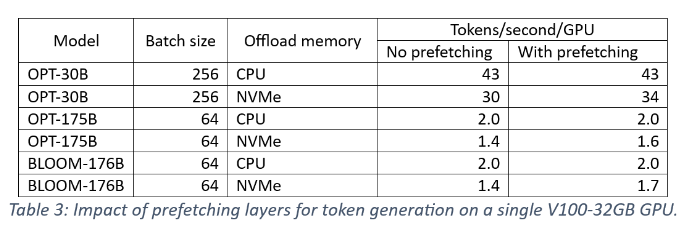

3. 여러 GPU에서 레이어 가져오기 병렬화

ZeRO-Inference는 GPU와 CPU 메모리 사이의 4개의 PCIe 상호 연결을 활용하여 여러 GPU에서 더 빠른 추론 계산을 위해 레이어 가져오기를 병렬화합니다.

- 단일 GPU와 2, 4개 GPU에서 토큰 처리량 향상을 봐보면

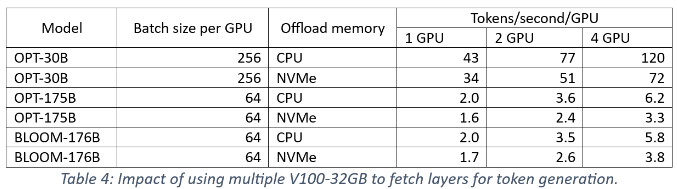

GPU당 집계된 PCIe 링크가 레이어 인출 대기 시간을 줄임에 따라 각 GPU에서 토큰 생성이 더 빨라짐을 보여줍니다

- 레이어 가져오는 걸 병렬화 해서 대기 시간을 줄임

## Zero-Inference를 사용해야 하는 경우

- ZeRO-Inference는 GPU 가속이 필요하지만 모델을 호스팅하기에는 충분한 GPU 메모리가 부족한 추론 애플리케이션을 위해 설계되었습니다.
  - 메모리가 모델보다 작지만 가속이 필요한 경우

- 또한 ZeRO-Inference는 처리량 지향 적이고 대규모 배치 크기 를 허용하는 추론 애플리케이션에 최적화되어 있습니다. 여러 GPU를 사용하여 전체 모델을 GPU 메모리에 맞추는 Accelerate , DeepSpeed-Inference 및 DeepSpeed-MII 와 같은 대체 기술 은 대기 시간에 민감하거나 배치 크기가 작은 추론 애플리케이션에 더 적합합니다.

# DeepSpeed-MII: 최대 40배 저렴한 추론으로 24,000개 이상의 오픈 소스 DL 모델에 대한 즉각적인 속도 향상

 Bloom 176B와 같은 매우 강력한 텍스트 생성 모델은 이제 hugging face와 같은 플랫폼을 통해 싱글 gpu에 엑세스 할 수 있다.

- 하지만 여전히 추론 대기 시간 및 비용이라는 두 가지 중요한 요소로 인해 제한을 받는다.

- 메모리적 문제는 해결됐지만 그 모델을 돌리는 시간은 해결이 안됨

기존 대기 시간과 비용을 줄이는 방법은 모델 추론 환경이 크기, 아키텍처, 시스템 성능 특성, 하드웨어 요구 사항등 다양한 모델이 존재하기 때문


- DeepSpeed ​​Model Implementations for Inference(MII)은 모델의 짧은 지연 시간, 저렴한 비용의 추론을 목표로 진행됨

- 적용 전과 후의 대기 시간과 비용 차이가 큼

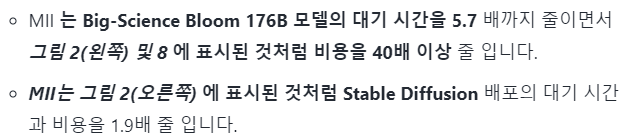



MII는 Transformer에 대해서 위와 같은 결과를 얻기 위해서 딥퓨전, 다중 GPU 추론을 위한 자동화된 텐서 슬라이싱(빠르게 슬라이싱하는 법?), 제로퀀트를 사용한 양자화 등을 사용함

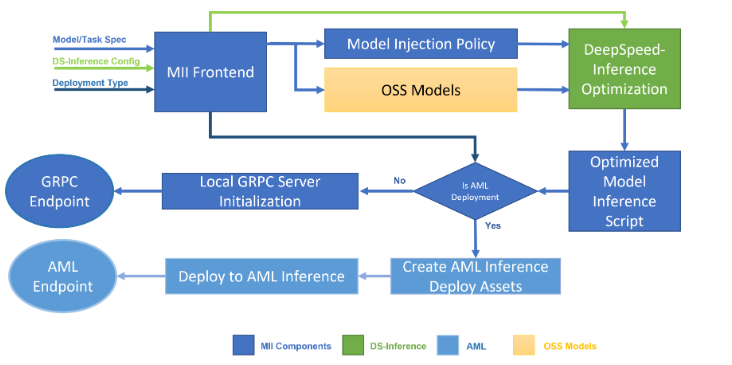

작동 과정표

Deep speed inference에 의해 구동됨, 모델 유형, 모델 크기, 배치 크기 및 사용 가능한 하드웨어 리소스를 기반으로 적절한 최적화들을 자동으로 적용하여 대기 시간을 최소화하고 처리량을 극대화함

- 지원되는 모델들이 정해져 있음

각 모델들의 최적화 방법들 설명

- 추론 워크로드는 기본 목표가 대기 시간 최소화인 경우 대기 시간이 중요하지만 기본 목표가 비용 최소화인 경우 비용에 민감한 것일 수 있습니다. 이 섹션에서는 대기 시간이 중요하고 비용에 민감한 시나리오 모두에 대해 MII를 사용할 때의 이점을 정량화합니다.

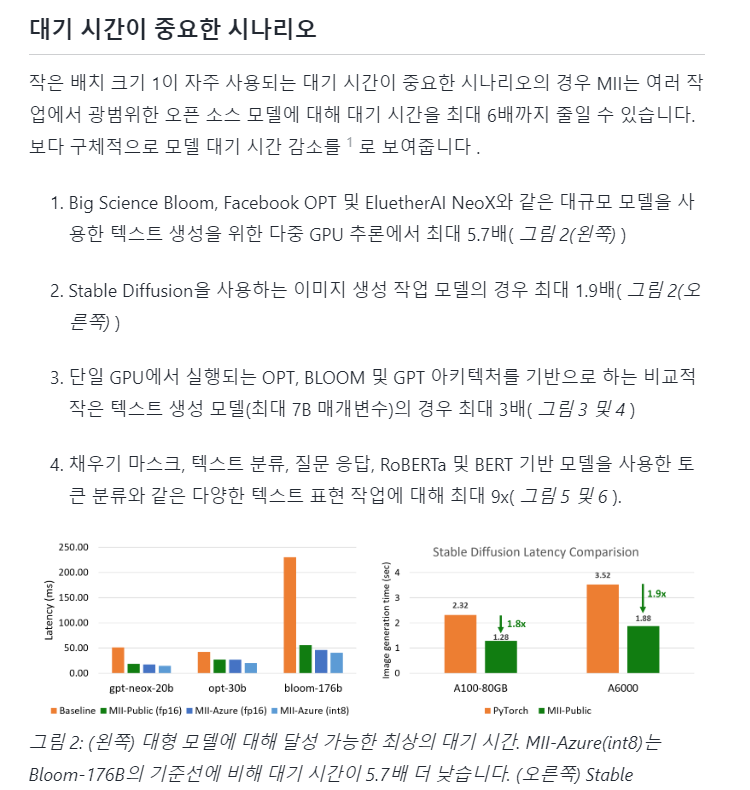

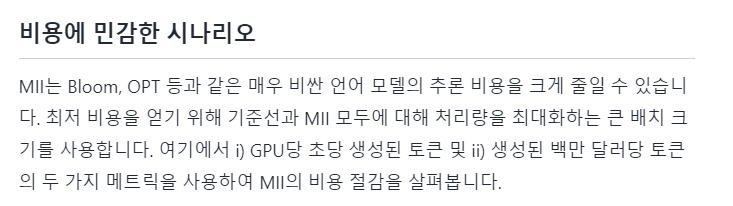

#  DeepSpeed로 대형 모델 교육

훈련이 가능한 이유 2가지

- Zero Redundancy Optimizer(Zero Redundancy Optimizer) 기반 기술
- 3차원 평행도 기반 기술(3D Parallelism based technologies)

zero

- 데이터 병렬처리에서 데이터 복제로 인한 비효율성 없이 사용 가능한 모든 GPU 장치의 총 GPU 메모리에 엑세스할 수있는 메모리 효율적인 데이터 병렬 처리 방식

3D 병렬화 기술
- 텐서 슬라이싱, 파이프라인 병렬화, 데이터 병렬화(또는 zero기반 데이터 병렬화) 라는 세 가지 다른 형태 병렬 기술의 조합으로 나타남

- 3가지를 결합하면 단점없이 각 기술의 강점을 활용할 수 있음
- ZeRo 기반 기술만으로 충반하지 않을 때 사용하면 교육 처리량 효율성이 좋아지지만 모델 코드 리팩토링(수정)이 필요함

#Zero-Inference를 사용해야 하는 경우


ZeRO-Inference는 GPU 가속이 필요하지만 모델을 호스팅하기에는 충분한 GPU 메모리가 부족한 추론 애플리케이션을 위해 설계되었습니다. 또한 ZeRO-Inference는 처리량 지향 적이고 대규모 배치 크기 를 허용하는 추론 애플리케이션에 최적화되어 있습니다. 여러 GPU를 사용하여 전체 모델을 GPU 메모리에 맞추는 Accelerate , DeepSpeed-Inference 및 DeepSpeed-MII 와 같은 대체 기술 은 대기 시간에 민감하거나 배치 크기가 작은 추론 애플리케이션에 더 적합합니다.

https://www.ciokorea.com/tags/101844/%EB%94%A5%EC%8A%A4%ED%94%BC%EB%93%9C/143556

딥스피드는 연산과 개발속도를 가속화하는 라이브러리

- 기존 하드웨어에서 딥러닝 모델을 학습하는데 있어 메모리 사용량을 줄이면서 더 나은 병렬처리를 이용하도록 설계됨

- 해당 모델로 이용할 수 있는 파라미터 개수를 늘리고(scaling)
  - 메모리에서 사용할 수 있는 파라미터 개수를 늘린다는 것 같음, 기존 15억개 파라미터에서 60억개 파라미터로 확장
- GPU 로컬 메모리를 효과적으로 활용하며
- 딥스피드에서 기존 파이토치 어플리케이션을 재사용할려고할 때 변경 작업을 최소화한다.

딥스피드의 속도향상은 기본 병렬처리를 향상하는데 있다.

- 파이토치의 분산 데이터 병렬 처리 시스템에서 엔비디아 V100 GPU 32GB를 사용하여 15억개의 파라미터 모델을 사용하는데 GPU에서 메모리 부족이 발생

- 하지만 딥스피드 이용시 동일한 디바이스에서 60억 개의 파라미터를 사용할 수 있다.

GPU 메모리를 효율적으로 사용하는 것도 딥스피드의 또 다른 개선점이라고 MS는 강조했다. GPU 전체에서 모델 학습을 분할해 필요한 데이터를 가까이에 둘 수 있고, 각 GPU의 메모리 사용량과 GPU 사이의 통신 오버헤드를 감소시킨다.

또한 딥스피드는 모델 학습 중에 더 많은 파라미터를 허용해 예측 정확도를 향상시킨다. 파라미터 또는 학습 과정 자체의 변수를 조정하는 것을 일컫는 하이퍼파라미터 최적화(Hyperparameter optimization)도 예측 정확성을 향상시킬 수 있지만, 이는 전형적으로 연구자의 경험이나 지식에만 의존하며 수동으로 이뤄진다.



## 딥스피드 유튜브

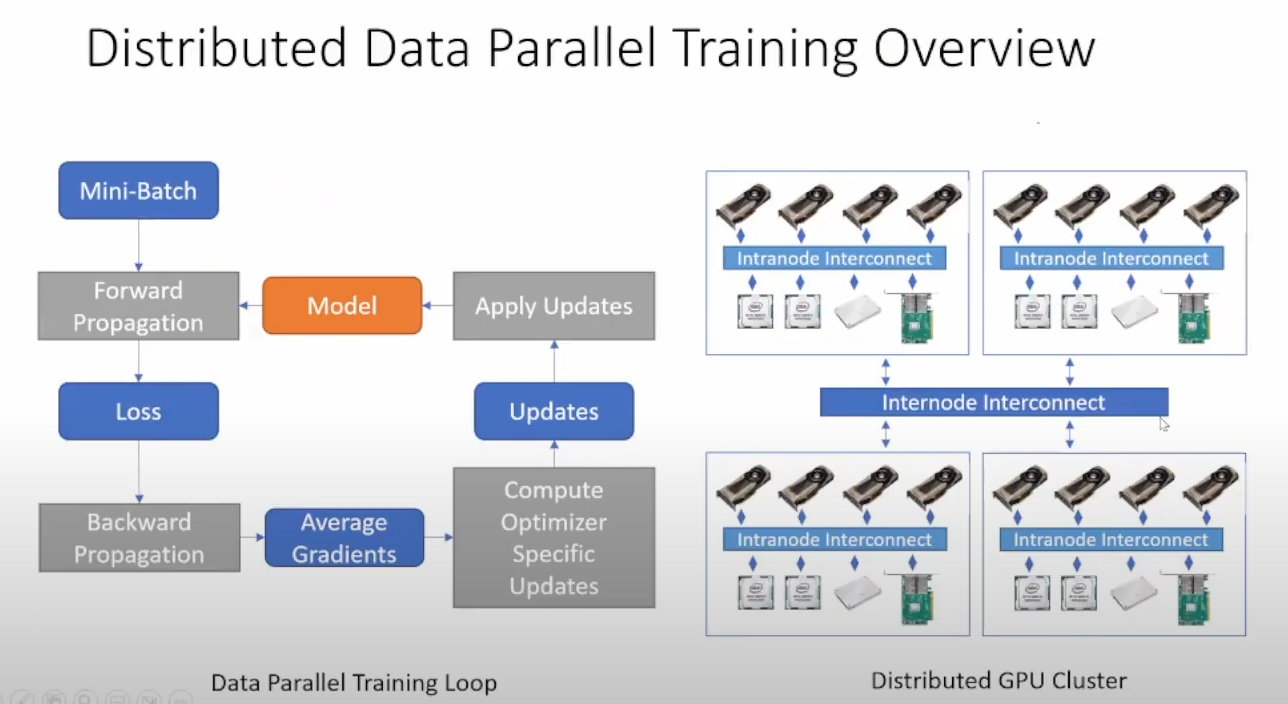

일반적인 데이터 병렬 교육은 여러 gpu에 있는 모델 복제본이 존재

왼쪽에 표시된 알고리즘을 실행하여 미니 배치를 가져오고 해당 미니 배치에서 손실을 구하기 위해 순전파를 진행하고 그걸로 역전파를 진행

- 여기서 기울기는 옵티마이저를 계산하는 모든 GPU에서 평균화가 됨

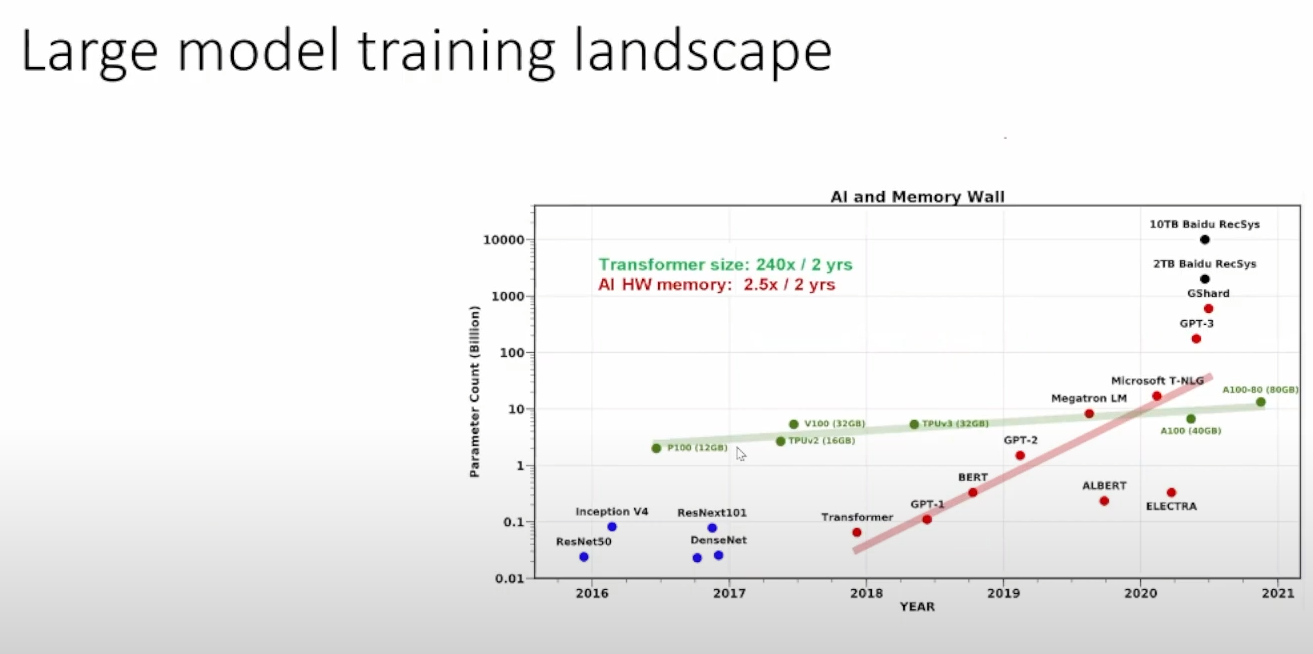

오늘날 모델들이 매우 빠른 속도로 커지고 있음

2년 동안 200배 성장 GPU 메모리는 훨씬 느리게 증가하고 있음

GPU 메모리는 기본적으로 더 큰 모델로 확장하는데 병목 현상이 발생
  - GPU 메모리 벽

학생이나 과학자들이 원할하게 fine-tuning, inference, 다운 스트리밍할 때 뭐가 필요할까? 수백개의 gpu

- 하지만 기업이 아니라면 이렇게 갖기 힘듬

이러한 문제를 해결하기 위한 방법들

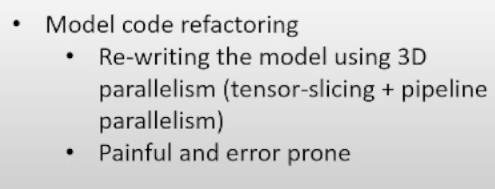

텐서 슬라이스, 파이프라인 병렬처리, 모델 병렬처리 등등

- 문제는 이러한 기술을 적용할려면 모델을 다시 작성해야함

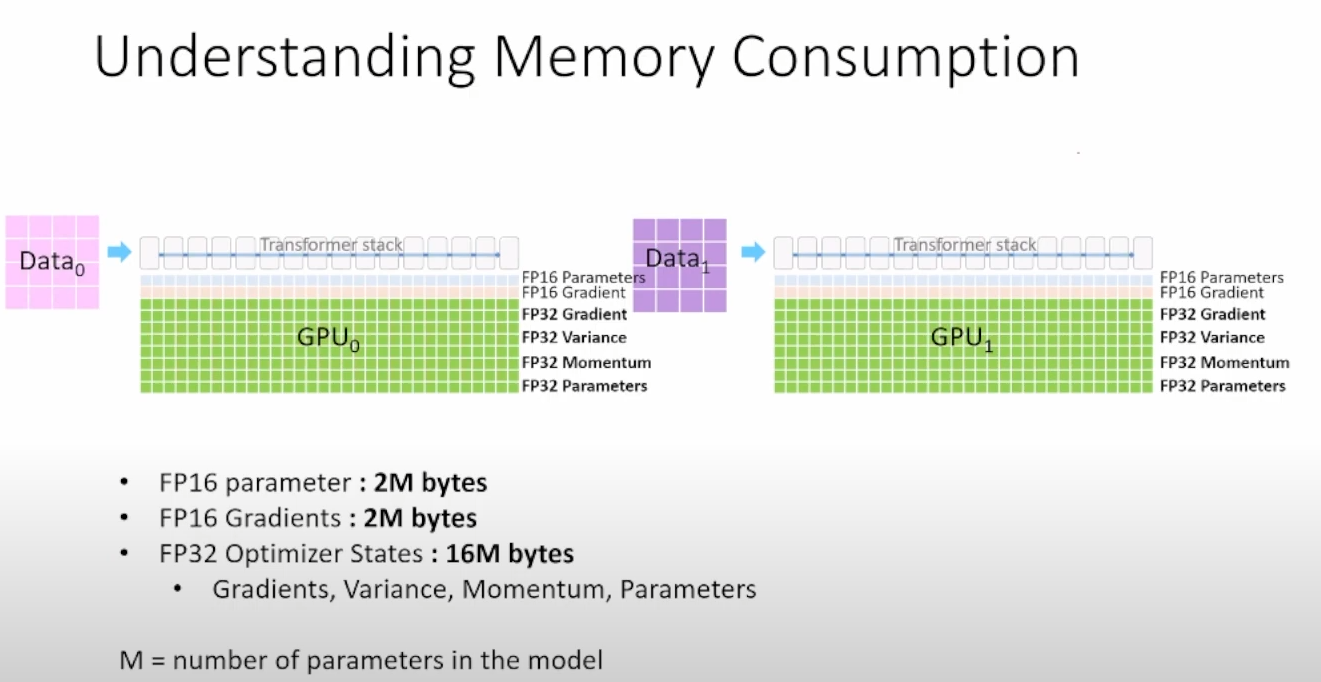

딥스피드가 어떻게 이러한 문제를 해결하는지 알아보기 전에 Atom 옵티마이저와 같은 것을 사용하여 mixed precision training을 고려한다면 모델 교육을 위한 메모리 소비가 어디서 발생하는지 알아보자

- FP16 매개변수를 표현하기 위해서는 약 2바이트가 필요
- 이 매개변수의 기울기도 동일하게 2바이트가 필요
- Optimizer state는 각 매개변수에 대해 16바이트를 필요로 함

즉 10억 개의 매개변수 모델이 GPU 메모리의 20기가를 차지한다는 것을 의미합니다.

이 메모리 소비는 입력 배치, 다음 입력 배치 메모리 같은 것들을 고려하지 않으므로 이 gpu 메모리 벽을 극복하기 위한 기술로 xero를 제안

- 딥러닝 상태의 gpu 메모리 비용은 기본적으로 기울기와 옵티마이저의 매개변수 및

## 유튜브 영상2

마이크로소프트에서 만든 언어모델 turning nlp는 거대함 17B = 170억개의 파라미터가 존재

- 인터넷, 레딧에서 가져온 것을 모델에서 훈련

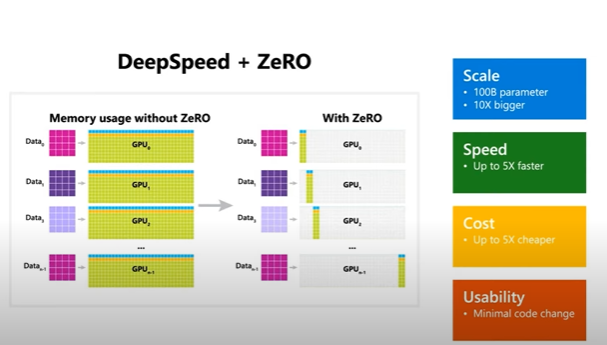

모델을 교육하는데 사용한 zero optimzer가 중요함

- 모델은 그냥 큰 transformer 모델임

딥스피드의 제로 옵티마이저가 아니었다면 훈련이 불가능했음

이 제로 옵티마이저 프로그램이 어떻게 동작하는지 살펴보자

여러 개의 gpu가 존재하는 경우 위 사진과 같이 작업을 수행, 이를 데이터 병렬 처리라고 합니다.

신경망이 하나의 디바이스에 다 들어간다면 그냥 넣어서 하면 됨 (데이터 병렬 처리)
- 너무 큰 모델은 안됨

하지만 모델이 너무 크다면 모델 일부를 각각 디바이스에 압축해야함
- 이 경우 디바이스가 쉬는 시간이 너무 길어짐

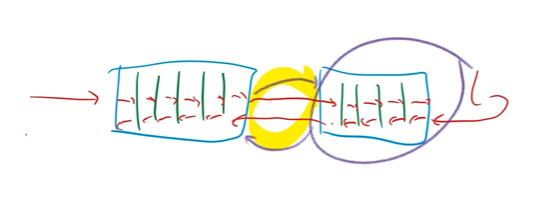

이렇게 두 디바이스(파란 네모)에 신경망을 나눠서 집어넣었는데 학습을 끝내고 역전파를 진행할 때 우선
- 두 번째 디바이스에서 손실을 계산하고 두 번째 디바이스에 존재하는 레이어를 업데이트
  - 이때 첫 번째 디바이스는 쉬고 있음
- 첫 번째 gpu 업데이트할 때 두 번째 gpu가 쉬고있음


> 오버헤드가 큼

특히 모델이 커서 이런 gpu가 많으면 더욱 문제가 됨

제로 옵티마이저는 데이터, 모델 병렬 처리를 모두 수행하므로 단일 모델에 비해 너무 큰 모델을 훈련이 가능

모델, 데이터 병렬 처리를 동시에 수행할 수 있으므로 기본적으로 모든 gpu가 항상 작동, 계산, 통신이 효율적

- ZeRO는 "데이터 병렬"을 획기적으로 최적화 하여 메모리 사용률을 최대화 해주는 메커니즘

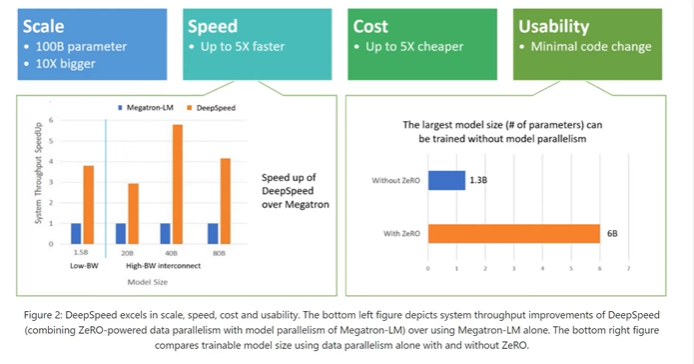

Nvdia가 교육한 이전 megatron LM 모델에 비해 평소보다 더 많은 속도 향상을 제공

GPU 사이 매우 빠른 버스를 이용한 속도 향상이 아닌 네트워크를 통해 매우 빠르게 만들 수 있음

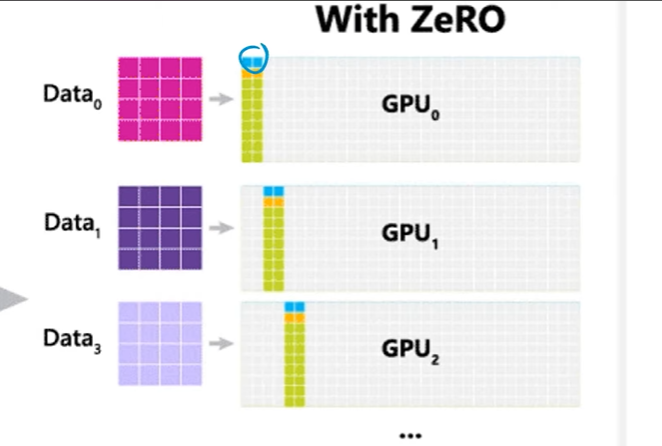

다음과 같이 gpu가 존재 모델을 분할해야함

- 모델이 분할되어서 메모리 용량이 넉넉해지고 데이터 병렬도 사용해서 진행

- 동그라미 쳐진 파란색 부분이 모델(파라미터)
- 그 아래 주황색 부분이 mem
- 파라미터 업데이트를 하는데 파라미터 개수 만큼의 기울기가 필요 = 초록 부분(SGD를 사용할 경우 필요없는 부분)
- 이 초록 부분에 degrade or atom을 가지고 있는 경우 유지해야하는 각 모델 파라미터에 대한 추가 파라미터가 존재
  - floating-point 3216 변환과 같은 상당한 오버헤드가 발생할수 도 있음



모델을 3개로 분할해보자

우리는 실제로 모델이 모든 데이터를 저장된 것 처럼 모델 전체에 pass가 되길 원함

- 그리고 모델이 나눠지지 않은 것 처럼 동작하길 원함

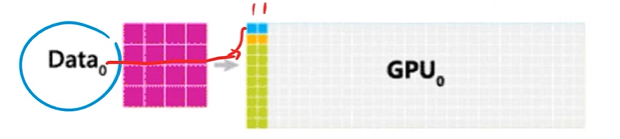

첫 번째 부분에 데이터0 이 두 레이어를 거쳐 진행이됨

- 중간 결과를 얻음


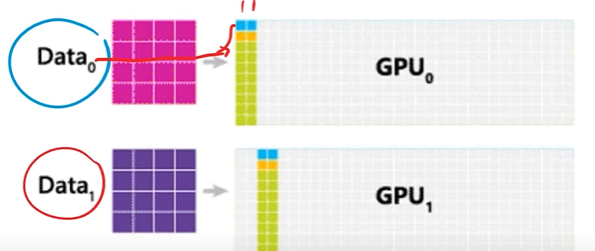

데이터 1을 GPU0로 보낼 수 없음 비용이 너무 비쌈

실제로 이 GPU에서 동시에 데이터를 계산하는 것 처럼 하고 싶음

- GPU1가 동작하기 전에 GPU0에 있던 모델 일부를 GPU1에 전달

- 이러면 GPU0에 있던 파라미터들로 데이터 1도 돌려볼 수 있음

그 다음 이걸 삭제 = 메모리 절약, 모든 시스템에서 모든 모델을 동기화한 상태로 유지하지 않고 필요한 부분을 보낸 다음 계산이 완료 되면 삭제

각 GPU 마다 사용하는 데이터 배치가 다르기 때문에 손실이 다르게 계산됨

https://www.microsoft.com/en-us/research/blog/zero-deepspeed-new-system-optimizations-enable-training-models-with-over-100-billion-parameters/?fbclid=IwAR1aVN2mWGOAuBLOwzo5wyeUwNVQi2R6vo5ugK7Qv9DfRwoUwDnidKS-IGo